<a href="https://colab.research.google.com/github/alvaroleva/TFG_collabs/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest classifier on different datasets**


This script will utlimately try to find the best RF model performing hyperparameter tunning with GridSearch on different datasets:

* **All the biomarkers**: all the 120 ECG-derived markers. 

* **Dataset 1**: best biomarkers (Correlation + Decision Trees + Univariate selection).
* **Dataseet 2**: best biomarkers + clinical data.
* **Dataset 3**: 5 best biomarkers for each lead (based on correlation).
* **Dataset 4**: 5 best biomarkers for each lead (based on correlation) + clinical data. 
* **Dataset 5**: 30 best biomarkers based only on univariate selection (SelectKBest).
* **Dataset 6**: 30 best biomarkers based only on Tree Classifier approach.



Import needed libraries

In [ ]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score,recall_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## 0A. Import Data: all the final **biomarkers** (after KNN imputation) and **clinical** variables

> Last result from [p02_FeatureSelection_DataVisualization](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=NxjMCC3QwbGC)

In [ ]:
#Code needed to import the Data from GoogleDrive
from google.colab import files
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

X_bmkclc_url = 'https://docs.google.com/spreadsheets/d/1Md6cxfAp4_AMZlBhSHQtWj_iXljjc7o8/edit?usp=share_link&ouid=111241553451068058703&rtpof=true&sd=true'
id = X_bmkclc_url.split("/")[-2] #get ID
downloaded = drive.CreateFile({'id':id}) #download from ID
downloaded.GetContentFile('X_bmkclc.xlsx') #Get the file in the Colab working directory

#load all the merged data
X_bmkclc = pd.read_excel('X_bmkclc.xlsx', index_col = 0)
X_bmkclc = X_bmkclc.reset_index(drop=True)
print('Original dataset shape: {}'.format(X_bmkclc.shape))

Original dataset shape: (26304, 131)


## 0B. Define the custom functions to split the beats data according to BHs. 


In [ ]:
def train_test_split_BH(data_BHsymp, rnd_state, test_siz = None, figures = 1):
    """
    Performs a stratified patient partition and returns the corresponding beat selection for train and test datasets. 
    
    INPUT ARGUMENTS:
    ## Data ##
    - data_BHsymp: a pandas dataframe with all the independent variables (biomarkers), the'BH' (patient BH code) 
    and the 'symp'target variable (1: symptomatic / 0: asymptomatic). Each row correspond to a beat. 
    *Note: the 'BH' and 'symp' column names must be respected. 

    ## train_test_split parameters ##
    -rnd_state = random_state
    -strat = stratify (takes y_BH by default)
    -test_siz = percentage from 0.0 to 1.0 of patients for test. If None, by default is taken as 25%.  
   
    Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
   
    ## figures ##
    -figures = binary number indicating if pie charts are displayed (1: show / 0: hide). Showed by 
    default (figures = 1). 
    
    OUTPUT ARGUMENTS:
    -X_train = biomarkers for train (independent variables)
    -X_test  = biomarkers for test  (independent variables)
    -y_train = labels for train (target variable 'symp')
    -y_test  = labels for test  (target variable 'symp')

    *Returned in the following order X_train,X_test,y_train, y_test. 

    """
    
    #Import train_test_split from sklearn
    from sklearn.model_selection import train_test_split

    #Define a dataframe with the all the BHs and their symp condition
    BH_symp   = data_BHsymp.groupby('BH').symp.first()
    BH_symp = pd.DataFrame(BH_symp.reset_index(drop = False)) #transform it to df

    #Split the BH PATIENTS in train and test 
    X_BH = BH_symp.BH   #a pandas Series with the BH numbers.
    y_BH = BH_symp.symp #the corresponding Series with the symptomatic condition of each BH (1: sympt / 0: asympt)


    XBH_train, XBH_test, yBH_train, yBH_test = train_test_split(X_BH, y_BH, 
        random_state= rnd_state, stratify = y_BH , test_size = test_siz) #perform the split
    
    if figures:
        print('*BH patient train-test split\n---------------------------\n')
        print("Train patients: {:.2f}% | 0: {} | 1: {}".format(len(XBH_train) / len(X_BH)*100, 
                                                        yBH_train.value_counts()[0],
                                                        yBH_train.value_counts()[1]      ))

        print("Test patients:  {:.2f}% | 0: {} | 1: {}".format(len(XBH_test) / len(X_BH)*100, 
                                                        yBH_test.value_counts()[0],
                                                        yBH_test.value_counts()[1]   ))
        
        import plotly.express as px
        #See train-test overall percentage
        fig = px.pie(values= [len(XBH_train), len(XBH_test)],  names = ['Train', 'Test'], width = 400, height = 400, title = 'Train-test BH patient split')
        fig.show()


        #See symp percentages in train
        fig = px.pie(values= yBH_train.value_counts(),  names = ['Asymptomatic', 'Symptomatic'], width = 400, height = 400, title = 'TRAIN: Symptomatic vs Asymptomatic patients')
        fig.show()

        #See symp percentages in test
        fig = px.pie(values= yBH_test.value_counts(),  names = ['Asymptomatic', 'Symptomatic'], width = 400, height = 400, title = 'TEST: Symptomatic vs Asymptomatic patients')
        fig.show()
    

    #TAKE the beats corresponding to the BH train-test split
    #Select all the beats for Train
    X_train = data_BHsymp[data_BHsymp.BH.isin(XBH_train)]      #biomarkers
    y_train = data_BHsymp[data_BHsymp.BH.isin(XBH_train)].symp #labels
    #Select all the beats for Test
    X_test = data_BHsymp[data_BHsymp.BH.isin(XBH_test)]        #biomarkers
    y_test = data_BHsymp[data_BHsymp.BH.isin(XBH_test)].symp   #labels
    

    #Reset the indexes
    X_train = X_train.reset_index(drop = True)
    X_test  = X_test.reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)
    
    X_train_wBH_Symp = X_train.copy()
    X_test_wBHsymp = X_test.copy()

    #Drop the BH patient's column and symp target variable from X_train and X_test
    # and reset the indexes
    X_train = X_train.drop(columns = ['BH', 'symp']).reset_index(drop = True)
    X_test  = X_test.drop(columns =  ['BH', 'symp']).reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    y_test  = y_test.reset_index(drop = True)
    
    return X_train,X_test,y_train, y_test, X_train_wBH_Symp,X_test_wBHsymp

In [ ]:
def StratifiedKFold_BH (data_BHsymp, n_splits_, random_state_, shuffle_ = True):
    """
    Mimicks the behaviour of StratifiedKFold but performing the train-test splits of each fold
    according to the BH patients, and then selects the corresponding beats
    
    INPUT ARGUMENTS:
    ## Data ##
    - data_BHsymp: a pandas dataframe with all the independent variables (biomarkers), the'BH' (patient BH code) 
    and the 'symp'target variable (1: symptomatic / 0: asymptomatic). Each row correspond to a beat. 
    *Note: the 'BH' and 'symp' column names must be respected. 

    ## StratifiedKFold parameters ##
    -n_splits_ = number of folds 
    -shuffle_ = Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.
    -random_state_ = When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. 
    
    Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    
    """
    BHs_in_data = data_BHsymp.BH.unique()
    symp_in_data = data_BHsymp.groupby('BH').symp.first()

    #Perform the StratifiedKfold split of the BH patients in the 'data' dataframe
    cv = StratifiedKFold(n_splits= n_splits_, shuffle= shuffle_, random_state = random_state_)
    BH_splits = list(cv.split(BHs_in_data, symp_in_data))

    #Select the beats from that patients to define the final train-test split
    cv_beats = []
    for trainBH_index, testBH_index in BH_splits: #iterate the BH indexes for each fold

        train_BH = BHs_in_data[trainBH_index] #take the BH numbers for train
        test_BH = BHs_in_data[testBH_index]   #take the BH numbers for test

        train_data = data_BHsymp[data_BHsymp['BH'].isin(train_BH)] #take the beats of the BH patients in train
        test_data = data_BHsymp[data_BHsymp['BH'].isin(test_BH)]   #take the beats of the BH patients in test

        train_data_idx = list(train_data.index) #extract the TRAIN beat indexes and convert to list
        test_data_idx  = list(test_data.index)  #extract the TEST beat indexes and convert to list

        tuple_train_test = (train_data_idx,test_data_idx) #generate a tuple with the train-test beat indexes for each fold
        return cv_beats.append(tuple_train_test)

# **1. Define the datasets**

## **All the dataset**: All the 120 biomarkers.


In [ ]:
tot_bmk = list(X_bmkclc.columns[11:].values)
X_bmk_all = X_bmkclc[ ['BH','symp'] + tot_bmk]
print('All biomarkers shape: {}'.format(X_bmk_all.shape))

All biomarkers shape: (26304, 122)


## **Dataset 1**: best biomarkers (Correlation + Decision Trees + Univariate selection).
Includes 19 best biomarkers


In [ ]:
tot_best_bmk = ['AreaQRSabs_aVF', 'Pavg_aVL', 'LP_QRSd_V4', 'AreaQRSabs_II', 'LP_QRSd_V1', 'AreaQRSabs_V3', 'LP_RMS40_V3', 'AreaQRSabs_V2', 'Pavg_aVF', 'Pavg_III', 'ST_slope_V3', 'ST_slope_II', 'LP_QRSd_V6', 'LP_QRSd_V3', 'ST_slope_V5', 'AreaQRSabs_aVL', 'AreaQRSabs_V1', 'AreaQRSabs_III', 'QTc_V6']
X_ds1 = X_bmkclc[ ['BH','symp'] + tot_best_bmk ] 
print('Dataset 1 shape: {}'.format(X_ds1.shape))

Dataset 1 shape: (26304, 21)


## **Dataset 2**: best biomarkers + all clinical data.
Includes 19 best biomarkers + 9 clinical variables


In [ ]:
tot_best_bmk = ['AreaQRSabs_aVF', 'Pavg_aVL', 'LP_QRSd_V4', 'AreaQRSabs_II', 'LP_QRSd_V1', 'AreaQRSabs_V3', 'LP_RMS40_V3', 'AreaQRSabs_V2', 'Pavg_aVF', 'Pavg_III', 'ST_slope_V3', 'ST_slope_II', 'LP_QRSd_V6', 'LP_QRSd_V3', 'ST_slope_V5', 'AreaQRSabs_aVL', 'AreaQRSabs_V1', 'AreaQRSabs_III', 'QTc_V6']
clinical_vars = ['Diagnosis_age', 'Gender', 'Proband', 'FH_SCD', 'FH_SCD_bef_55', 'SD_VF_bef_Dg', 'sponECGtype1_all', 'AF_bef_Dg', 'EPS_inducib_dic']
X_ds2 = X_bmkclc[ ['BH','symp'] + tot_best_bmk + clinical_vars] 
print('Dataset 2 shape: {}'.format(X_ds2.shape))

Dataset 2 shape: (26304, 30)


## **Dataset 3**: 5 best biomarkers for each lead (based on correlation).
Includes 58 best biomarkers (5 from each lead but excluding 2 LP_LAS)


In [ ]:
tot_best5lead_bmk = ['PR_I', 'ST_60_I', 'ST_0_I', 'LP_QRSd_I', 'qt_I', 
'ST_0_II', 'ST_slope_II', 'PR_II', 'qt_II', 'AreaQRSabs_II',
'AreaQRSabs_III', 'Pavg_III' ,'PR_III', 'qt_III', 'LP_QRSd_III',
'ST_60_aVR', 'LP_RMS40_aVR', 'ST_0_aVR', 'PR_aVR', 'qt_aVR', 
'Pavg_aVL', 'AreaQRSabs_aVL', 'PR_aVL', 'qt_aVL', 'ST_60_aVL', 
'ST_0_aVF', 'AreaQRSabs_aVF', 'ST_slope_aVF', 'PR_aVF', 'Pavg_aVF',
'ST_60_V1', 'LP_QRSd_V1', 'PR_V1', 'qt_V1', 'AreaQRSabs_V1', 
'ST_60_V2', 'AreaQRSabs_V2', 'ST_0_V2', 'PR_V2', 'LP_QRSd_V2',
'ST_60_V3', 'LP_QRSd_V3', 'PR_V3', 'AreaQRSabs_V3', 'LP_RMS40_V3',
'LP_QRSd_V4', 'ST_60_V4', 'ST_0_V4', 'qt_V4',
'ST_slope_V5', 'ST_0_V5', 'qt_V5', 'QTc_V5','PR_V5',
'QTc_V6', 'LP_QRSd_V6', 'qt_V6', 'ST_slope_V6' ]

X_ds3 = X_bmkclc[ ['BH','symp'] + tot_best5lead_bmk ] 
print('Dataset 3 shape: {}'.format(X_ds3.shape))

Dataset 3 shape: (26304, 60)


## **Dataset 4**: 5 best biomarkers for each lead (based on correlation) + clinical data.
Includes 58 best biomarkers (5 from each lead but excluding 2 LP_LAS) + clinical data. 


In [ ]:
X_ds4 = X_bmkclc[ ['BH','symp'] + tot_best5lead_bmk +  clinical_vars] 
print('Dataset 3 shape: {}'.format(X_ds4.shape))

Dataset 3 shape: (26304, 69)


## **Dataset 5**: best biomarkers and clinical variable based on univariate selection (SelectKBest).
Repeat what it was done in [3.2.3 Univariate selection](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=_cHtUC3zwbxo) but now taken into account also the clinical data. 

Includes the **30 best features** including both biomarkers and clinical data. 


In [ ]:
#UNIVARIATE SELECTION
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_features = X_bmkclc.drop(columns = ['BH','symp'] )
y_symp = X_bmkclc.symp

bestfeatures = SelectKBest(score_func = f_classif, k = 10)
fit = bestfeatures.fit(abs(X_features),y_symp)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_features.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print(featureScores.nlargest(30,'Score'))
best_30ft_univ = featureScores.nlargest(30,'Score').Features
best_30ft_univ = list(best_30ft_univ)

#Dataframe ´
X_ds5 = X_bmkclc[ ['BH','symp'] + best_30ft_univ ] 
print('Dataset 5 shape: {}'.format(X_ds5.shape))

           Features        Score
5      SD_VF_bef_Dg  7469.770235
4     FH_SCD_bef_55  2982.416154
7         AF_bef_Dg  2920.911071
49         Pavg_aVL  2005.623674
13           ST_0_I  1949.765142
50   AreaQRSabs_aVL  1938.968299
94         ST_60_V3  1344.318640
115     ST_slope_V5  1244.798462
2           Proband  1194.595471
44        ST_60_aVR  1089.913178
113         ST_0_V5  1087.675960
97       LP_QRSd_V3  1052.730879
30   AreaQRSabs_III  1049.672080
122          QTc_V6   978.527817
80    AreaQRSabs_V2   936.262937
77       LP_QRSd_V1   910.829249
107      LP_QRSd_V4   895.497776
25      ST_slope_II   890.102311
21            qt_II   818.797288
74         ST_60_V1   777.096646
84         ST_60_V2   771.459984
26            PR_II   740.618943
54        ST_60_aVL   728.226895
111           qt_V5   720.631624
60   AreaQRSabs_aVF   715.445371
116           PR_V5   709.034599
23          ST_0_II   699.410605
127      LP_QRSd_V6   694.730526
61           qt_aVF   657.537262
96        

## **Dataset 6**: best biomarkers based only on Tree Classifier approach

Repeat what it was done in [3.2.2 Tree Classifier approach](https://colab.research.google.com/drive/1ebdLWv-O7FurtHxEVpgi4ute8-b-gOSn#scrollTo=_cHtUC3zwbxo) but now taken into account also the clinical data. 

Includes the **30 best features** including both biomarkers and clinical data. 


In [ ]:
#Tree Classifier 
from sklearn.ensemble import ExtraTreesClassifier
feature_importances = []

n_trials = 3
for i in range(n_trials):
    model = ExtraTreesClassifier(random_state= i )
    model.fit(X_features, y_symp) #the same inputs as before
    feature_importances.append(model.feature_importances_)

# Aggregate feature importances for each trial
average_importances = np.mean(feature_importances, axis=0)
feat_importances = pd.Series(average_importances, index=X_features.columns)

# Select the top 30 features
best_30ft_tree = list(feat_importances.nlargest(30).index)

#Dataframe ´
X_ds6 = X_bmkclc[ ['BH','symp'] + best_30ft_tree ] 
print('Dataset 6 shape: {}'.format(X_ds6.shape))


Dataset 6 shape: (26304, 32)


In [ ]:
best_30ft_tree

['SD_VF_bef_Dg',
 'FH_SCD_bef_55',
 'AF_bef_Dg',
 'Diagnosis_age',
 'sponECGtype1_all',
 'EPS_inducib_dic',
 'Gender',
 'FH_SCD',
 'Pavg_aVL',
 'PR_V5',
 'ST_0_I',
 'AreaQRSabs_aVL',
 'AreaQRSabs_III',
 'Pavg_II',
 'Proband',
 'Pavg_aVF',
 'LP_QRSd_V4',
 'Pavg_III',
 'PR_V6',
 'ST_60_aVR',
 'LP_QRSd_V6',
 'AreaQRSabs_V2',
 'AreaQRSabs_aVF',
 'LP_QRSd_V3',
 'ST_slope_I',
 'LP_QRSd_aVL',
 'LP_QRSd_I',
 'ST_60_V3',
 'PR_II',
 'ST_slope_V5']

> Perform the feature selection based on ``ExtraTreesClassifier`` but modifing 3 times the ``random_state`` to ensure more robustneess. It end up with the 30 common features that have an average better importance on the 3 randomizations.

**For better readability a dictionary will be done containing the 6 datasets.**

In [ ]:
all_datasets = {'All_biomarkers': X_bmk_all,'Dataset_1': X_ds1,'Dataset_2': X_ds2, 'Dataset_3': X_ds3,'Dataset_4': X_ds4, 'Dataset_5': X_ds5, 'Dataset_6':X_ds6}

# **2. Find the best RF model**


In [ ]:
model = RandomForestClassifier()

### **1. First try RF with default parameters**



In [ ]:
default_results_ds = [];
for dataset_name, dataset in all_datasets.items():
  print(dataset_name)

  #A. Define the X,y
  X = dataset.drop(columns = ['BH', 'symp'])
  y = dataset.symp

  X_wBH_Symp = dataset #needed input for StratifiedKFold_BH (in this case corresponds to the raw datasets)

    #B.3 Cross validation score with all data to assess the performance of the model for each dataset
  n_scores = []
  n_trials = 3
  for i in range(n_trials):
    #define the cross-validation strategy to validate the model (using the custom function)
    cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

    #evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    #save the mean scores
    n_scores.append(np.mean(scores))
    mean_cv_nscore = np.mean(n_scores)

    #Save RESULTS: The mean ROC_AUC cv score for each dataset
  default_results_ds.append({
      'Dataset' : dataset_name,
      'AUC_roc_mean_cvscore': mean_cv_nscore
      
  })

df_DatasetResults = pd.DataFrame(default_results_ds,columns=['Dataset', 'AUC_roc_mean_cvscore'])

All_biomarkers
Dataset_1
Dataset_2
Dataset_3
Dataset_4
Dataset_5
Dataset_6


In [ ]:
df_DatasetResults

,Dataset,AUC_roc_mean_cvscore
0,All_biomarkers,0.695793
1,Dataset_1,0.661242
2,Dataset_2,0.804735
3,Dataset_3,0.700324
4,Dataset_4,0.829603
5,Dataset_5,0.909855
6,Dataset_6,0.845074


### Further exploration - subset analyisis

From the analysis of the different datasets and feature selection we can see that default Random Forest achieves the best perfomance with **Dataset 5: 30 best biomarkers based only on univariate selection (SelectKBest)**.

Therefore, let's try to optimize the performance with this approach. Before GridSearchCV hyperparameter tunning, let's study what's the optimal number of features. For that, we will study **subsets of Dataset  5** generated with different number of best features from univariate selection: *Subset_<#features>*. 

In [ ]:
#Define the subsets
X_ds5_subsets = {'Subset_{}'.format(n_feat) : X_bmkclc[ ['BH','symp'] + list(featureScores.nlargest(n_feat,'Score').Features) ] 
                 for n_feat in range(10,61,10)  } #Generate a subset with the top n_feat from univariate selection.

#Show the shape of each subset (apart from the #features, BH and symp columns must be considered)
for subs in X_ds5_subsets.keys():
  print(subs + ': ',X_ds5_subsets[subs].shape)

Subset_10:  (26304, 12)
Subset_20:  (26304, 22)
Subset_30:  (26304, 32)
Subset_40:  (26304, 42)
Subset_50:  (26304, 52)
Subset_60:  (26304, 62)


In [ ]:
for ft in X_ds5_subsets['Subset_30'].columns:
  print(ft)

BH
symp
SD_VF_bef_Dg
FH_SCD_bef_55
AF_bef_Dg
Pavg_aVL
ST_0_I
AreaQRSabs_aVL
ST_60_V3
ST_slope_V5
Proband
ST_60_aVR
ST_0_V5
LP_QRSd_V3
AreaQRSabs_III
QTc_V6
AreaQRSabs_V2
LP_QRSd_V1
LP_QRSd_V4
ST_slope_II
qt_II
ST_60_V1
ST_60_V2
PR_II
ST_60_aVL
qt_V5
AreaQRSabs_aVF
PR_V5
ST_0_II
LP_QRSd_V6
qt_aVF
PR_V3


In [ ]:
#Assess the default XGBoost performance for each subset
default_results_subsets = [];
for subset_name, subset in X_ds5_subsets.items():

  #A. Define the X,y
  X = subset.drop(columns = ['BH', 'symp'])
  y = subset.symp

  X_wBH_Symp = subset #needed input for StratifiedKFold_BH (in this case corresponds to the raw subsets)

    #B.Cross validation score with all data to assess the performance of the model for each subset
  n_scores = []
  n_trials = 5
  for i in range(n_trials):
    #define the cross-validation strategy to validate the model (using the custom function)
    cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

    #evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    #save the mean scores
    n_scores.append(np.mean(scores))
    mean_cv_nscore = np.mean(n_scores)

    #Save RESULTS: The mean ROC_AUC cv score for each subset
  default_results_subsets.append({
      'Subset' : subset_name,
      'AUC_roc_mean_cvscore': mean_cv_nscore
      
  })

df_SubsetResults = pd.DataFrame(default_results_subsets,columns=['Subset', 'AUC_roc_mean_cvscore'])

In [ ]:
df_SubsetResults

,Subset,AUC_roc_mean_cvscore
0,Subset_10,0.867202
1,Subset_20,0.901361
2,Subset_30,0.901315
3,Subset_40,0.883163
4,Subset_50,0.865475
5,Subset_60,0.859721


### **2. GridSearchCV hyperparameter tunning with the best combination**


In [ ]:
best_ds = X_ds5_subsets['Subset_20']

TRAIN-TEST split

In [ ]:
X_train, X_test, y_train, y_test, X_train_wBH_Symp,X_test_wBH_Symp = train_test_split_BH(best_ds, rnd_state = 0, figures = 0)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print('\n')
print('TRAIN: Symptomatic vs Asymptomatic beat count')
print(y_train.value_counts())
print('\n')
print('TEST:  Symptomatic vs Asymptomatic beat count')
print(y_test.value_counts())

X_train shape: (19592, 20)
y_train shape: (19592,)
X_test shape: (6712, 20)
y_test shape: (6712,)


TRAIN: Symptomatic vs Asymptomatic beat count
0    16340
1     3252
Name: symp, dtype: int64


TEST:  Symptomatic vs Asymptomatic beat count
0    5875
1     837
Name: symp, dtype: int64


* **Hyperparameter tuning**  ``GridSearchCV``

In [ ]:
# Define the parameter grid
p_grid = {
    'n_estimators': [100, 300, 500, 700],  # Number of trees in the forest
    'max_depth': [None, 5, 10],             # Maximum depth of the tree
}

# Loop for each trial
num_trials = 3
non_nested_scores = np.zeros(num_trials)# Array to store scores
for i in range(num_trials):

    # Selecting stratified cross-validation technique for preserving the data distribution
    outer_cv = StratifiedKFold_BH (X_train_wBH_Symp, n_splits_ = 4, random_state_ = i, shuffle_ = True)#define the outer loop with 4folds 

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator= model, param_grid=p_grid, cv=outer_cv, scoring = 'roc_auc')
    print('Hyperparameter tunning has started | Waiting for the results...')
    clf.fit(X_train, y_train) #DO IT WITH TRAIN 
    print('Hyperparameter tunning has finished | Saving the results...')
    
    #Results
    non_nested_scores[i] = clf.best_score_

    #Save results
    best_params = clf.best_params_
    best_estimator = clf.best_estimator_
    results = clf.cv_results_
    print(best_params)
    print(best_estimator)

    # Export GridSearchCV results into a dataframe for better view
    df_results = pd.DataFrame(results)

    #Download results in local 
    from google.colab import files

    df_results.to_excel('RF_bestds_GridSearch{}.xlsx'.format(i))
    # download the file to your local PC
    files.download('RF_bestds_GridSearch{}.xlsx'.format(i))

In [ ]:
best_model = RandomForestClassifier(n_estimators=300)

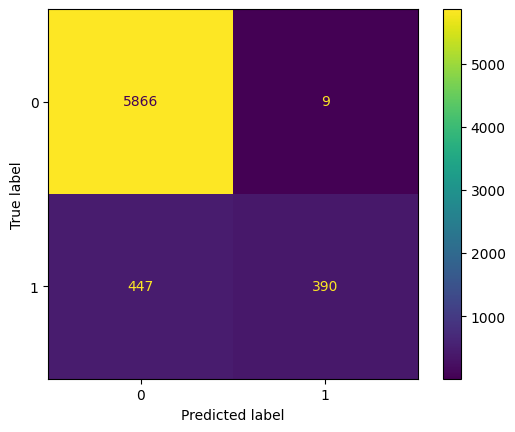

Accuracy:  0.932061978545888
AUC roc:  0.7322089529474567
Sensitivity: 46.595 %
Specificity: 99.847 %
                  precision    recall  f1-score   support

Asymptomatic (0)       0.93      1.00      0.96      5875
 Symptomatic (1)       0.98      0.47      0.63       837

        accuracy                           0.93      6712
       macro avg       0.95      0.73      0.80      6712
    weighted avg       0.94      0.93      0.92      6712



In [ ]:
best_model.fit(X_train, y_train) #training
y_pred = best_model.predict(X_test) #predictions


#confusion matrix
labels_str= [0,1]

cm = confusion_matrix(y_test, y_pred, labels= labels_str)
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_str)
cm_fig.plot()

plt.show()

tn, fp, fn, tp = cm.ravel()

# compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('AUC roc: ' , roc_auc_score(y_test,y_pred))
print('Sensitivity: {:.3f} %'.format(sensitivity*100))
print('Specificity: {:.3f} %'.format(specificity*100))

target_names = ['Asymptomatic (0)', 'Symptomatic (1)']
print(classification_report(y_test, y_pred, target_names=target_names))


### **Final cross-validation**

In [ ]:
best_ds = X_ds5_subsets['Subset_20']
best_model  = RandomForestClassifier(n_estimators=300)

#A. Define the X,y
X = best_ds.drop(columns = ['BH', 'symp'])
y = best_ds.symp

X_wBH_Symp = best_ds #needed input for StratifiedKFold_BH (in this case corresponds to the raw datasets)

#Cross validation score with all data to assess the performance of the model for each dataset
mean_cv_AUC = []
mean_cv_recall = []
mean_cv_specificity = []

n_trials = 3
for i in range(n_trials):
  #define the cross-validation strategy to validate the model (using the custom function)
  cv = StratifiedKFold_BH (X_wBH_Symp, n_splits_ = 6, random_state_ = i, shuffle_ = True) #X_train_wBH_Symp output from the custom function (See the section above)

  #evaluate the model
  cv_AUCs = cross_val_score(best_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
  cv_recalls = cross_val_score(best_model, X, y, scoring='recall', cv=cv, n_jobs=-1)  
  #save the mean scores
  mean_cv_AUC.append(np.mean(cv_AUCs))
  mean_cv_recall.append(np.mean(cv_recalls))

print(np.mean(mean_cv_AUC))
print(np.mean(mean_cv_recall))

# Export GridSearchCV results into a dataframe for better view
df_results = pd.DataFrame(results)

#Download results in local 
from google.colab import files

df_results.to_excel('RF_bestds_GridSearch{}.xlsx'.format(i))
# download the file to your local PC
files.download('RF_bestds_GridSearch{}.xlsx'.format(i))

0.9074327731708899
0.5430314855769662
